# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2025
## deadline: 12.2.2025 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Mst Ayesha Sultana

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 7-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Read in the datasets

In [3]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).

# Given csv files do't have a header, setting header=None ensures that pandas treats all rows as data.
input_data = pd.read_csv('input.csv', header=None)
output_data = pd.read_csv('output.csv', header=None)
coordinates = pd.read_csv('coordinates.csv', header=None)

# Print out the dataset dimensions
print("Input data dimension:", input_data.shape)
print("Output data dimension:", output_data.shape)
print("Coordinates dimension:", coordinates.shape)

Input data dimension: (1691, 75)
Output data dimension: (1691, 1)
Coordinates dimension: (1691, 2)


### Standardization of the predictor features (input.csv)

In [7]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 

scaler = StandardScaler()
input_data_standardized = scaler.fit_transform(input_data)


### Functions and analysis code

In [10]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

In [13]:
# Calculate the distance matrix
distance_matrix = cdists(coordinates.values) # returns a 2D array of size 1691*1691, as we have 1691 data points in total

print("Dimension of distance matrix:", distance_matrix.shape)

Dimension of distance matrix: (1691, 1691)


In [15]:
# generate distance parameter values, distance_values = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m).
distance_values = range(0, 301, 20)

In [17]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

# 7-nearest neighbor regression model
knn = KNeighborsRegressor(n_neighbors=7, metric='euclidean')

# Array to save the c-index values for all distances
c_indices = []

# Estimate the water permeability prediction performance (using 7NN model and C-index)
for d in distance_values:
    all_y_true = []
    all_y_pred = []
    
    for i in range(len(input_data_standardized)):
        
        # For the ith test data point, discard data points within distance d
        # we are checking which of the current training data samples are at most d distance away geographically from the test sample i. 
        reduced_samples = distance_matrix[i] > d

        # Build model using reduced training set
        X_train = input_data_standardized[reduced_samples]
        y_train = output_data.values[reduced_samples]

        # ith data point as a test data
        X_test = input_data_standardized[i].reshape(1, -1) 
        y_test = output_data.values[i]

        #  at least 7 neighbors are required to make a valid prediction.
        if len(X_train) >= 7:
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            all_y_true.append(y_test)
            all_y_pred.append(y_pred)
    
    # Compute C-index for all predictions at distance d
    if len(all_y_true) > 0:
        c_indices.append(cindex(all_y_true, all_y_pred))
    else:
        c_indices.append(np.nan)

# Analysis of the results
print("C-index values for each distance:", c_indices)

C-index values for each distance: [0.7143865081776044, 0.7061014602515088, 0.7003135110012333, 0.6916410365531849, 0.6846337611940716, 0.6809306356034824, 0.6148976872001557, 0.5978313214219219, 0.5933417934873146, 0.5913007171765391, 0.5876374891681564, 0.5849853498877968, 0.5835563864829791, 0.5840390072361615, 0.5839214143622896, 0.5835045896218689]


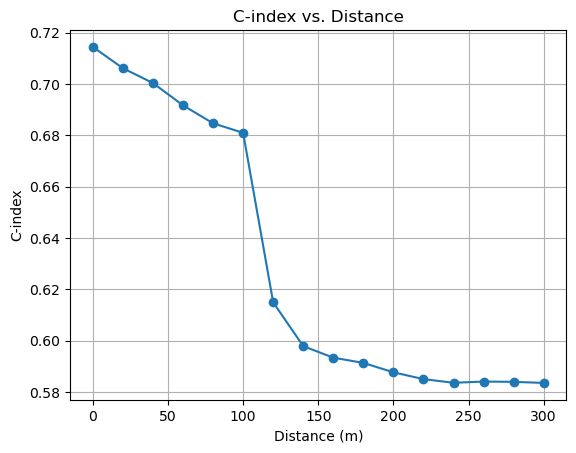

In [15]:
# Visualize the results
plt.plot(distance_values, c_indices, marker='o')
plt.xlabel('Distance (m)')
plt.ylabel('C-index')
plt.title('C-index vs. Distance')
plt.grid(True)
plt.show()

## Analysis of the results

### In this cell, you need to answer the client's questions:


 1. What happens to the 7NN performance as the prediction distance increases?

    As the prediction distance increases, we observe a <b> clear decline in performance </b> based on the C-index values. The 7NN model, when predicting water permeability, becomes less accurate as it starts incorporating data points that are farther away spatially from the query point. This trend suggests that <b> spatial proximity plays a crucial role </b> in the accuracy of predictions. Neighboring data points that are spatially closer to the query point tend to have more relevant information, resulting in better prediction accuracy. As the distance grows, the relevance of the neighbors diminishes, and predictions become less reliable.

 3. Do you think the results behave as was somewhat expected? Do they make sense, why?

    Yes, <b> the results are consistent with expectations. </b> Spatial data typically exhibits spatial autocorrelation, meaning that observations that are geographically closer tend to be more similar. This is a fundamental assumption in many spatial modeling tasks. The closer a data point is to the query point, the more likely it is to share similar environmental or spatial characteristics, which improves the accuracy of predictions. When the distance between neighbors increases, the assumption of spatial similarity weakens, causing a drop in prediction performance. Therefore, the decline in performance as the distance increases makes perfect sense in this context, as we are dealing with spatial data where proximity is key to prediction accuracy.

 3. If we require that the 7NN must have at least C-index performance of 0.68, then up to what distance should we trust the 7NN predictions, based on the results?

    From the observed trend, a sharp drop in performance occurs around the 100-meter mark, where the C-index value begins to fall below 0.68. Based on this, we can confidently say that the model's predictions are reliable up to a distance of about 100 meters. Beyond this threshold, the prediction performance deteriorates, and the model's reliability becomes questionable. Therefore, to provide the client with meaningful advice, we could recommend: <b> "You can trust the 7NN model for water permeability predictions within a 100-meter range. Beyond this range, the model’s predictive accuracy declines significantly, and we do not suggest relying on it alone for predictions after this point." </b>